# Representation Learning

Here, we’ll look at two simple ways to pre-process the groups so that they look similar to each other. The purpose of this is to decrease unfairness. Again, we’ll use the Adult dataset.

In [1]:
import numpy as np
from   mmd  import MMD_torch
import pandas as pd 
import torch
import torchvision.models  as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from   tqdm import tqdm
from   torch.utils.data import DataLoader, TensorDataset
from   sklearn.mixture import GaussianMixture
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = np.load("adult/adult_train.npz")

In [4]:
header = np.loadtxt("adult/adult_headers.txt", dtype = str )

In [5]:
train_data_X = pd.DataFrame(train_data["x"], columns= header[:-1])
train_data_Y = pd.DataFrame(train_data["y"], columns= [header[-1]])
train_data_A = pd.DataFrame(train_data["a"], columns = ["gender"])

In [6]:
data = pd.concat((train_data_X, train_data_Y, train_data_A), axis = 1)

In [7]:
test_data = np.load("adult/adult_test.npz")
test_data_X = pd.DataFrame(test_data["x"], columns= header[:-1])
test_data_Y= pd.DataFrame(test_data["y"], columns= [header[-1]])
test_data_A = pd.DataFrame(test_data["a"], columns = ["gender"])

In [8]:
class PandasDF(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDF, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame()
        return torch.from_numpy(df.values).float()

In [9]:
class BinaryClassifier(nn.Module):
    def __init__(self, in_features, n_hidden = 128):
        super(BinaryClassifier, self).__init__()
        
        self.linear_network = nn.Sequential(
                                    nn.Linear(in_features, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, n_hidden),
                                    nn.ReLU(),
                                    nn.Linear(n_hidden, 1))
        
    def forward(self, x):
        return self.linear_network(x)

In [10]:
def train_model(model, criterion, optimizer, dataloader, num_epoch, alpha, withMMD = False):
    model.train()
    
    for epoch in tqdm(range(num_epoch)):
        train_loss = 0.
        for i, (data, label, a) in enumerate(dataloader):
            
            output = model(data)
            if withMMD:
                 loss = criterion(output, label) + alpha * MMD_torch(output, a)
            else:
                loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(data)/ float(len(dataloader.dataset))
        
        
        if epoch % 50 == 0:
            print("Epoch: ", epoch, "Loss: ", [train_loss])
        
    print("Training Loss: ", train_loss)
    
    print("Done Training")

    
def test_model(model, dataloader):
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        n_A_zero = 0
        n_A_one = 0
        dp_A_zero = 0
        dp_A_one = 0
        for i, (data, label, sensitive) in enumerate(dataloader):

                output = model(data)
                predicted = torch.tensor((output.squeeze() > 0.).long()).reshape((-1,1))
                
                for item in range(len(sensitive)):
                    if sensitive[item] == 0:
                        n_A_zero += 1
                        dp_A_zero += predicted[item].item()
                    else:
                        n_A_one += 1
                        dp_A_one += predicted[item].item()
                
                accuracy += np.equal(predicted, label).sum().item()
        
        mean_dif = dp_A_zero / n_A_zero - dp_A_one / n_A_one
            
        print("Test accuracy is: ", accuracy / len(dataloader.dataset))
        print("Mean difference: ", mean_dif)
        print("Demographic parity is: ", np.abs(mean_dif))
        
    return accuracy / len(dataloader.dataset) , np.abs(mean_dif)

In [11]:
def train_model_(model, criterion, optimizer, dataloader, num_epoch, alpha, withMMD = False):
    model.train()
    
    for epoch in tqdm(range(num_epoch)):
        train_loss = 0.
        for i, (data, _, label) in enumerate(dataloader):
            
            output = model(data)
            if withMMD:
                loss = criterion(output, label) + alpha * MMD_torch(output, label)
            else:
                loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(data)/ float(len(dataloader.dataset))
        
        
        if epoch % 50 == 0:
            print("Epoch: ", epoch, "Loss: ", [train_loss])
        
    print("Training Loss: ", train_loss)
    
    print("Done Training")

    
def test_model_(model, dataloader):
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        n_A_zero = 0
        n_A_one = 0
        sum_zero = 0
        sum_one = 0
        for i, (data, _, sensitive) in enumerate(dataloader):

                output = model(data)
                predicted = torch.tensor((output.squeeze() > 0.).long()).reshape((-1,1))
                
                for item in range(len(sensitive)):
                    if sensitive[item] == 0:
                        n_A_zero += 1
                        sum_zero += predicted[item].item() == sensitive[item].item()
                    else:
                        n_A_one += 1
                        sum_one += predicted[item].item() == sensitive[item].item()
                
                accuracy += np.equal(predicted, sensitive).sum().item()
        racc = 0.5 * (sum_zero / n_A_zero + sum_one / n_A_one)
            
        print("Test accuracy is: ", accuracy / len(dataloader.dataset))
        print("Reweighted accuracy is: ", racc)

#### preprocess the data using means and variances from gaussians fitted on each feature then train a classifier for predicting $A$ and $Y$

In [12]:
# get the features for group A = 0

train_XA0 = data[data.gender != 1].drop(labels = ["income", "gender"],axis=1)


# get the features for group A = 1

train_XA1 = data[data.gender != 0].drop(labels = ["income", "gender"],axis=1)

In [13]:

#definition of the gaussians
Gaussian0 = GaussianMixture(covariance_type = "diag")
Gaussian0.fit(train_XA0)

Gaussian1 = GaussianMixture(covariance_type = "diag")
Gaussian1.fit(train_XA1)


mean_A0 = Gaussian0.means_
cov_A_0 = Gaussian0.covariances_[0]

mean_A1 = Gaussian1.means_
cov_A_1 = Gaussian1.covariances_[0]

In [14]:
# preprocessing the data 
train_data_X_ = train_data_X.copy()
for row in range(train_data_X.shape[0]):
    if train_data_A.iloc[row].values[0] == 0:
        train_data_X_.iloc[row, ] = (train_data_X.iloc[row, ].values.copy() - mean_A0) /np.sqrt(cov_A_0)
    else:
        train_data_X_.iloc[row, ] = (train_data_X.iloc[row, ].values.copy() - mean_A1) /np.sqrt(cov_A_1)

In [15]:

data_ = pd.concat((train_data_X_, train_data_A), axis = 1)

# features A = 0
train_XA0_ = data_[data_.gender != 1].drop(labels = ["gender"], axis=1)

# the features  A = 1
train_XA1_ = data_[data_.gender != 0].drop(labels= ["gender"],axis=1)


In [16]:
train_data_t  = PandasDF(train_data_X_, train_data_Y, train_data_A)
train_loader_ = DataLoader(train_data_t, batch_size = 64, shuffle = True, drop_last = True) 

In [17]:
# learn a classifier g to predict Y from this preprocessed data

in_features = train_loader_.dataset.tensors[0].shape[-1]
g = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(g.parameters())
num_epoch = 200

train_model(g, criterion, optimizer, train_loader_, num_epoch, 0, False)

  0%|          | 1/200 [00:01<03:59,  1.20s/it]

Epoch:  0 Loss:  [0.3652493045823635]


 26%|██▌       | 51/200 [01:16<04:01,  1.62s/it]

Epoch:  50 Loss:  [0.17083496548928054]


 50%|█████     | 101/200 [02:33<02:28,  1.50s/it]

Epoch:  100 Loss:  [0.14597807826487982]


 76%|███████▌  | 151/200 [03:49<01:14,  1.53s/it]

Epoch:  150 Loss:  [0.13186770041083146]


100%|██████████| 200/200 [05:06<00:00,  1.54s/it]

Training Loss:  0.13241332724911475
Done Training


In [18]:
data_test = pd.concat((test_data_X, test_data_Y, test_data_A), axis = 1)

In [19]:
# get the features for group A = 0 for test data

test_XA0 = data_test[data_test.gender != 1].drop(labels = ["income", "gender"], axis=1)


# get the features for group A = 1 for test data

test_XA1 = data_test[data_test.gender != 0].drop(labels = ["income", "gender"],axis=1)

In [20]:
#fit gaussian for features of group A = 0 for test data
Gaussiant0 = GaussianMixture(covariance_type = "diag")
Gaussiant0.fit(test_XA0)

mean_tA0 = Gaussiant0.means_
cov_tA0 = Gaussiant0.covariances_[0]

#fit gaussian for features of group A = 1 for test data
Gaussiant1 = GaussianMixture(covariance_type = "diag")
Gaussiant1.fit(test_XA1)

mean_tA1 = Gaussiant1.means_
cov_tA1 = Gaussiant1.covariances_[0]

In [21]:
# preprocessing the test data with learned gaussian means and variances
test_data_X_ = test_data_X.copy()
for row in range(test_data_X.shape[0]):
    if test_data_A.iloc[row].values[0] == 0:
        test_data_X_.iloc[row, ] = (test_data_X.iloc[row, ].values.copy() - mean_tA0) /np.sqrt(cov_tA0)
    else:
        test_data_X_.iloc[row, ] = (test_data_X.iloc[row, ].values.copy() - mean_tA1) /np.sqrt(cov_tA1)

In [22]:
test_data_t  = PandasDF(test_data_X_, test_data_Y, test_data_A)
test_loader_ = DataLoader(test_data_t, batch_size = 64, shuffle = True, drop_last = False) 

In [23]:
#evaluate performace of classifier g on preprocessed test set with accuracy and DP
test_model(g, test_loader_)

Test accuracy is:  0.8251950125913642
Mean difference:  -0.17155348394467596
Demographic parity is:  0.17155348394467596


(0.8251950125913642, 0.17155348394467596)

In [24]:
# learn a classifier h to predict A from this preprocessed data

in_features = train_loader_.dataset.tensors[0].shape[-1]
h = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(h.parameters())
num_epoch = 200

train_model_(h, criterion, optimizer, train_loader_, num_epoch, 0, False)

  0%|          | 1/200 [00:01<04:23,  1.32s/it]

Epoch:  0 Loss:  [0.15755315889290317]


 26%|██▌       | 51/200 [01:27<04:36,  1.86s/it]

Epoch:  50 Loss:  [2.92888504518544e-11]


 50%|█████     | 101/200 [03:04<03:19,  2.02s/it]

Epoch:  100 Loss:  [1.46444252259272e-11]


 76%|███████▌  | 151/200 [04:53<01:53,  2.31s/it]

Epoch:  150 Loss:  [2.0564079127969155e-08]


100%|██████████| 200/200 [07:09<00:00,  2.75s/it]

Training Loss:  0.0
Done Training


In [25]:
# evaluate performance of classifier h on preprocessed test set with accuracy and reweighted accuracy
test_model_(h, test_loader_)

Test accuracy is:  0.9995700509796696
Reweighted accuracy is:  0.9995391362218342


#### implement the use of Maximum Mean Discrepancy to make the features from both classes of the gender $A$ indistinguishable on the average.

In [26]:
train_data_t  = PandasDF(train_data_X, train_data_Y, train_data_A)
train_loader = DataLoader(train_data_t, batch_size = 64, shuffle = True, drop_last = True) 

In [27]:
# predicting Y with MMD

in_features = train_loader.dataset.tensors[0].shape[-1]
model = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
num_epoch = 200
alpha = 0.1
train_model(model, criterion, optimizer, train_loader, num_epoch, alpha, True)

  0%|          | 1/200 [00:02<07:30,  2.26s/it]

Epoch:  0 Loss:  [0.47300643343322263]


 26%|██▌       | 51/200 [02:20<07:03,  2.84s/it]

Epoch:  50 Loss:  [0.2755403583990902]


 50%|█████     | 101/200 [04:45<04:51,  2.95s/it]

Epoch:  100 Loss:  [0.22712826694406396]


 76%|███████▌  | 151/200 [07:18<02:34,  3.15s/it]

Epoch:  150 Loss:  [0.2070820349220021]


100%|██████████| 200/200 [09:53<00:00,  3.21s/it]

Training Loss:  0.19836549854685673
Done Training


In [28]:
test_data_t  = PandasDF(test_data_X, test_data_Y, test_data_A)
test_loader = DataLoader(test_data_t, batch_size = 64, shuffle = True, drop_last = False) 

In [29]:
test_model(model, test_loader)

Test accuracy is:  0.8361280019654812
Mean difference:  -0.17009792081337055
Demographic parity is:  0.17009792081337055


(0.8361280019654812, 0.17009792081337055)

In [30]:
# predicting A with MMD
in_features = train_loader.dataset.tensors[0].shape[-1]
model1 = BinaryClassifier(in_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters())
num_epoch = 200
alpha = 0.1
train_model_(model1, criterion, optimizer, train_loader, num_epoch, alpha, True)

  0%|          | 1/200 [00:02<07:38,  2.30s/it]

Epoch:  0 Loss:  [0.23888845514897494]


 26%|██▌       | 51/200 [02:39<08:30,  3.42s/it]

Epoch:  50 Loss:  [0.07826437572051809]


 50%|█████     | 101/200 [05:38<06:05,  3.69s/it]

Epoch:  100 Loss:  [0.07097312691979725]


 76%|███████▌  | 151/200 [08:56<03:25,  4.19s/it]

Epoch:  150 Loss:  [0.07834522869625678]


100%|██████████| 200/200 [12:38<00:00,  4.70s/it]

Training Loss:  0.07766129313125639
Done Training


In [31]:
test_model_(model1, test_loader)

Test accuracy is:  0.969535040845157
Reweighted accuracy is:  0.9542519830289615


#### range of values of the hyperparameter $\alpha$ and investigate the influence of the values of $\alpha$ on the accuracy $acc$ and demographic parity $ \Delta_{DP}$ on the test set.

In [32]:
alpha_range = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0])
criterion = nn.BCEWithLogitsLoss()
in_features = train_loader.dataset.tensors[0].shape[-1]

In [34]:
# generate a range of values for accuracy anf dp using different alpha values
accuracy_range = []
dp_range = []
for alpha in alpha_range:
    print("###############################")
    print("for value of alpha=", alpha)
    print("###############################")
    model_alpha = BinaryClassifier(in_features)
    optimizer = optim.Adam(model_alpha.parameters())
    train_model(model_alpha, criterion, optimizer, train_loader, 100, alpha, True)
    acc , dp = test_model(model_alpha, test_loader)
    accuracy_range.append(acc)
    dp_range.append(dp)
    

  0%|          | 0/100 [00:00<?, ?it/s]

###############################
for value of alpha= 0.0001
###############################


  1%|          | 1/100 [00:01<03:13,  1.96s/it]

Epoch:  0 Loss:  [0.4199958410673403]


 51%|█████     | 51/100 [02:15<02:16,  2.78s/it]

Epoch:  50 Loss:  [0.26137669684461456]


100%|██████████| 100/100 [04:34<00:00,  2.82s/it]


Training Loss:  0.22001415895107235
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8411645476322093
Mean difference:  -0.17018296964638235
Demographic parity is:  0.17018296964638235
###############################
for value of alpha= 0.0005
###############################


  1%|          | 1/100 [00:02<03:50,  2.33s/it]

Epoch:  0 Loss:  [0.4334081843555324]


 51%|█████     | 51/100 [02:24<02:22,  2.92s/it]

Epoch:  50 Loss:  [0.26147834875598186]


100%|██████████| 100/100 [04:46<00:00,  2.90s/it]


Training Loss:  0.21853391859331556
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8424543946932007
Mean difference:  -0.1807777917062865
Demographic parity is:  0.1807777917062865
###############################
for value of alpha= 0.001
###############################


  1%|          | 1/100 [00:02<03:46,  2.29s/it]

Epoch:  0 Loss:  [0.43870187326334453]


 51%|█████     | 51/100 [02:26<02:20,  2.87s/it]

Epoch:  50 Loss:  [0.258393056686803]


100%|██████████| 100/100 [04:46<00:00,  3.04s/it]


Training Loss:  0.2159667943678743
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8420244456728703
Mean difference:  -0.1681669708856799
Demographic parity is:  0.1681669708856799
###############################
for value of alpha= 0.005
###############################


  1%|          | 1/100 [00:02<03:52,  2.35s/it]

Epoch:  0 Loss:  [0.43449224939085906]


 51%|█████     | 51/100 [02:25<02:24,  2.94s/it]

Epoch:  50 Loss:  [0.259733221615193]


100%|██████████| 100/100 [04:49<00:00,  2.96s/it]


Training Loss:  0.21920991055938546
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8395061728395061
Mean difference:  -0.17524375739527376
Demographic parity is:  0.17524375739527376
###############################
for value of alpha= 0.01
###############################


  1%|          | 1/100 [00:02<03:54,  2.37s/it]

Epoch:  0 Loss:  [0.42472267130376684]


 51%|█████     | 51/100 [02:24<02:19,  2.85s/it]

Epoch:  50 Loss:  [0.2599913749789721]


100%|██████████| 100/100 [04:43<00:00,  2.81s/it]


Training Loss:  0.216959886134123
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8392604876850316
Mean difference:  -0.17663995450473452
Demographic parity is:  0.17663995450473452
###############################
for value of alpha= 0.05
###############################


  1%|          | 1/100 [00:02<03:47,  2.30s/it]

Epoch:  0 Loss:  [0.41817345702235537]


 51%|█████     | 51/100 [02:22<02:21,  2.88s/it]

Epoch:  50 Loss:  [0.2699639184854016]


100%|██████████| 100/100 [04:42<00:00,  2.87s/it]


Training Loss:  0.22674465409360847
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8466924636078865
Mean difference:  -0.18686522944840048
Demographic parity is:  0.18686522944840048
###############################
for value of alpha= 0.1
###############################


  1%|          | 1/100 [00:02<03:43,  2.26s/it]

Epoch:  0 Loss:  [0.4070741973218071]


 51%|█████     | 51/100 [02:25<02:24,  2.94s/it]

Epoch:  50 Loss:  [0.27478383941383266]


100%|██████████| 100/100 [04:51<00:00,  3.01s/it]


Training Loss:  0.23504506996517746
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8446041397948529
Mean difference:  -0.19847049687067175
Demographic parity is:  0.19847049687067175
###############################
for value of alpha= 0.5
###############################


  1%|          | 1/100 [00:02<03:45,  2.28s/it]

Epoch:  0 Loss:  [0.4806442991791943]


 51%|█████     | 51/100 [02:37<02:38,  3.23s/it]

Epoch:  50 Loss:  [0.3330901594552404]


100%|██████████| 100/100 [05:18<00:00,  3.36s/it]


Training Loss:  0.30272703978270027
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8481051532461151
Mean difference:  -0.1559061293251841
Demographic parity is:  0.1559061293251841
###############################
for value of alpha= 1.0
###############################


  1%|          | 1/100 [00:02<03:45,  2.28s/it]

Epoch:  0 Loss:  [0.5260098796120576]


 51%|█████     | 51/100 [02:43<02:48,  3.45s/it]

Epoch:  50 Loss:  [0.3828037006915569]


100%|██████████| 100/100 [05:39<00:00,  3.73s/it]


Training Loss:  0.36378895330295796
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8478594680916406
Mean difference:  -0.1429811526894082
Demographic parity is:  0.1429811526894082
###############################
for value of alpha= 5.0
###############################


  1%|          | 1/100 [00:02<03:48,  2.30s/it]

Epoch:  0 Loss:  [0.6358461651512537]


 51%|█████     | 51/100 [03:03<03:04,  3.76s/it]

Epoch:  50 Loss:  [0.551419902091669]


100%|██████████| 100/100 [06:12<00:00,  4.00s/it]


Training Loss:  0.5513251412321575
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0
###############################
for value of alpha= 10.0
###############################


  1%|          | 1/100 [00:02<03:44,  2.27s/it]

Epoch:  0 Loss:  [0.752961095869276]


 51%|█████     | 51/100 [03:02<03:06,  3.81s/it]

Epoch:  50 Loss:  [0.5512825363204634]


100%|██████████| 100/100 [06:10<00:00,  3.98s/it]


Training Loss:  0.5514188074501077
Done Training
Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0


Text(0.5, 1.0, 'A plot of alpha values against accuracy')

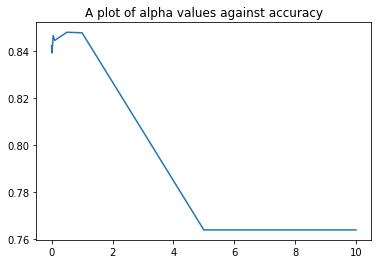

In [35]:
# generate a plot of acc and dp against range of alpha values
plt.plot(alpha_range, accuracy_range)
plt.title("A plot of alpha values against accuracy")

Text(0.5, 1.0, 'A plot of alpha values against dp')

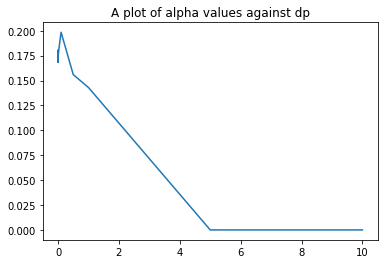

In [36]:
plt.plot(alpha_range, dp_range)
plt.title("A plot of alpha values against dp")


In [37]:
alpha_range_2 = np.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0])

In [38]:
# generate a range of values for accuracy anf dp using different alpha values
accuracy_range_2 = []
dp_range_2 = []
for alpha in alpha_range_2:
    print("###############################")
    print("for value of alpha=", alpha)
    print("###############################")
    model_alpha = BinaryClassifier(in_features)
    
    optimizer = optim.Adam(model_alpha.parameters())
    train_model(model_alpha, criterion, optimizer, train_loader, 100, alpha, True)
    acc , dp = test_model(model_alpha, test_loader)
    accuracy_range_2.append(acc)
    dp_range_2.append(dp)

  0%|          | 0/100 [00:00<?, ?it/s]

###############################
for value of alpha= 1e-05
###############################


  1%|          | 1/100 [00:02<03:58,  2.41s/it]

Epoch:  0 Loss:  [0.4222617020628524]


 51%|█████     | 51/100 [02:27<02:21,  2.90s/it]

Epoch:  50 Loss:  [0.260784723363225]


100%|██████████| 100/100 [04:47<00:00,  2.90s/it]


Training Loss:  0.2133758361339351
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8394447515508875
Mean difference:  -0.18388561568934397
Demographic parity is:  0.18388561568934397
###############################
for value of alpha= 5e-05
###############################


  1%|          | 1/100 [00:02<03:54,  2.37s/it]

Epoch:  0 Loss:  [0.4568145167699107]


 51%|█████     | 51/100 [02:27<02:25,  2.96s/it]

Epoch:  50 Loss:  [0.26428461290102184]


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


Training Loss:  0.21903009336471607
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8422701308273448
Mean difference:  -0.18371674101432836
Demographic parity is:  0.18371674101432836
###############################
for value of alpha= 0.0001
###############################


  1%|          | 1/100 [00:02<03:50,  2.33s/it]

Epoch:  0 Loss:  [0.406297511614525]


 51%|█████     | 51/100 [02:28<02:26,  2.98s/it]

Epoch:  50 Loss:  [0.26012741397981753]


100%|██████████| 100/100 [04:51<00:00,  2.92s/it]


Training Loss:  0.21455366377682455
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8348995761931085
Mean difference:  -0.1818524950545301
Demographic parity is:  0.1818524950545301
###############################
for value of alpha= 0.0005
###############################


  1%|          | 1/100 [00:02<03:53,  2.36s/it]

Epoch:  0 Loss:  [0.4147044881798009]


 51%|█████     | 51/100 [02:27<02:22,  2.90s/it]

Epoch:  50 Loss:  [0.2599462057843351]


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


Training Loss:  0.21932168193027635
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8442970333517598
Mean difference:  -0.1736811315928133
Demographic parity is:  0.1736811315928133
###############################
for value of alpha= 0.001
###############################


  1%|          | 1/100 [00:02<03:53,  2.36s/it]

Epoch:  0 Loss:  [0.41670002616164603]


 51%|█████     | 51/100 [02:27<02:21,  2.89s/it]

Epoch:  50 Loss:  [0.2613183017415681]


100%|██████████| 100/100 [04:50<00:00,  2.93s/it]


Training Loss:  0.21947987103564004
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8408574411891161
Mean difference:  -0.18270446116544925
Demographic parity is:  0.18270446116544925
###############################
for value of alpha= 0.005
###############################


  1%|          | 1/100 [00:02<03:58,  2.41s/it]

Epoch:  0 Loss:  [0.44978095572716964]


 51%|█████     | 51/100 [02:27<02:24,  2.95s/it]

Epoch:  50 Loss:  [0.2623666076657811]


100%|██████████| 100/100 [04:51<00:00,  2.93s/it]


Training Loss:  0.21928329385178888
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8430071862907684
Mean difference:  -0.15518690869658713
Demographic parity is:  0.15518690869658713
###############################
for value of alpha= 0.01
###############################


  1%|          | 1/100 [00:02<03:48,  2.30s/it]

Epoch:  0 Loss:  [0.44565426338612607]


 51%|█████     | 51/100 [02:26<02:26,  2.98s/it]

Epoch:  50 Loss:  [0.263314789721979]


100%|██████████| 100/100 [04:50<00:00,  2.96s/it]


Training Loss:  0.21735679342890166
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8460782507217002
Mean difference:  -0.1681688053721918
Demographic parity is:  0.1681688053721918
###############################
for value of alpha= 0.05
###############################


  1%|          | 1/100 [00:02<03:51,  2.34s/it]

Epoch:  0 Loss:  [0.42828272329252914]


 51%|█████     | 51/100 [02:31<02:26,  2.98s/it]

Epoch:  50 Loss:  [0.26684419988930536]


100%|██████████| 100/100 [04:55<00:00,  2.93s/it]


Training Loss:  0.2326819824427756
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8388919599533198
Mean difference:  -0.1756922383894839
Demographic parity is:  0.1756922383894839
###############################
for value of alpha= 0.1
###############################


  1%|          | 1/100 [00:02<03:51,  2.34s/it]

Epoch:  0 Loss:  [0.4579670276854484]


 51%|█████     | 51/100 [02:31<02:27,  3.02s/it]

Epoch:  50 Loss:  [0.27732429572930467]


100%|██████████| 100/100 [05:01<00:00,  3.07s/it]


Training Loss:  0.23394822894214382
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8415944966525398
Mean difference:  -0.16759828006697913
Demographic parity is:  0.16759828006697913
###############################
for value of alpha= 0.5
###############################


  1%|          | 1/100 [00:02<03:52,  2.35s/it]

Epoch:  0 Loss:  [0.49319788230834355]


 51%|█████     | 51/100 [02:41<02:44,  3.35s/it]

Epoch:  50 Loss:  [0.3356028593112621]


100%|██████████| 100/100 [05:29<00:00,  3.50s/it]


Training Loss:  0.3080379947764161
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8492721577298692
Mean difference:  -0.18749848400072971
Demographic parity is:  0.18749848400072971
###############################
for value of alpha= 1.0
###############################


  1%|          | 1/100 [00:02<03:53,  2.36s/it]

Epoch:  0 Loss:  [0.540180419990294]


 51%|█████     | 51/100 [02:45<02:51,  3.49s/it]

Epoch:  50 Loss:  [0.3779758260531336]


100%|██████████| 100/100 [05:39<00:00,  3.60s/it]


Training Loss:  0.36320849488025403
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.8506848473680978
Mean difference:  -0.13838933103411022
Demographic parity is:  0.13838933103411022
###############################
for value of alpha= 5.0
###############################


  1%|          | 1/100 [00:02<03:55,  2.38s/it]

Epoch:  0 Loss:  [0.6247577239033318]


 51%|█████     | 51/100 [03:08<03:14,  3.97s/it]

Epoch:  50 Loss:  [0.5514006613659946]


100%|██████████| 100/100 [06:24<00:00,  4.09s/it]


Training Loss:  0.5511654005352047
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0
###############################
for value of alpha= 10.0
###############################


  1%|          | 1/100 [00:02<03:50,  2.33s/it]

Epoch:  0 Loss:  [0.7375254622988042]


 51%|█████     | 51/100 [03:07<03:10,  3.89s/it]

Epoch:  50 Loss:  [0.5512762256857915]


100%|██████████| 100/100 [06:20<00:00,  4.05s/it]


Training Loss:  0.5511988960280876
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0
###############################
for value of alpha= 50.0
###############################


  1%|          | 1/100 [00:02<03:52,  2.35s/it]

Epoch:  0 Loss:  [1.6151228043895458]


 51%|█████     | 51/100 [03:10<03:12,  3.94s/it]

Epoch:  50 Loss:  [0.5512453438129232]


100%|██████████| 100/100 [06:24<00:00,  4.05s/it]


Training Loss:  0.5512131999419912
Done Training


  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0
###############################
for value of alpha= 100.0
###############################


  1%|          | 1/100 [00:02<03:50,  2.33s/it]

Epoch:  0 Loss:  [1.5144052014319116]


 51%|█████     | 51/100 [03:13<03:14,  3.96s/it]

Epoch:  50 Loss:  [0.5511125876970094]


100%|██████████| 100/100 [06:29<00:00,  4.12s/it]


Training Loss:  0.5513061476458185
Done Training
Test accuracy is:  0.7637737239727289
Mean difference:  0.0
Demographic parity is:  0.0


Text(0.5, 1.0, 'A plot of alpha values against accuracy')

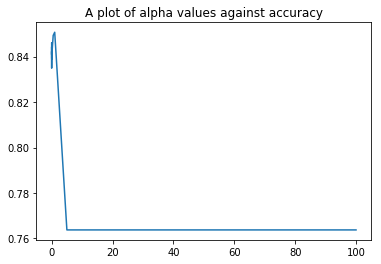

In [39]:
# generate a plot of acc and dp against range of alpha values
plt.plot(alpha_range_2, accuracy_range_2)
plt.title("A plot of alpha values against accuracy")

Text(0.5, 1.0, 'A plot of alpha values against dp')

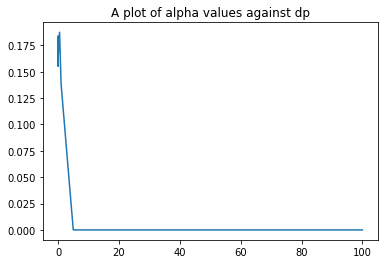

In [40]:
plt.plot(alpha_range_2, dp_range_2)
plt.title("A plot of alpha values against dp")